In [17]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Checking available device (CPU/GPU)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Defining data transformations

In [19]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading dataset

In [20]:
dataset = torchvision.datasets.ImageFolder(root=r'/kaggle/input/SeaIceData', transform=data_transforms)

# Splitting dataset into training and testing sets


In [21]:
train_size = int(0.7 * len(dataset)) 
valid_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))  
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Generate a random sample of 10 images from the test dataset


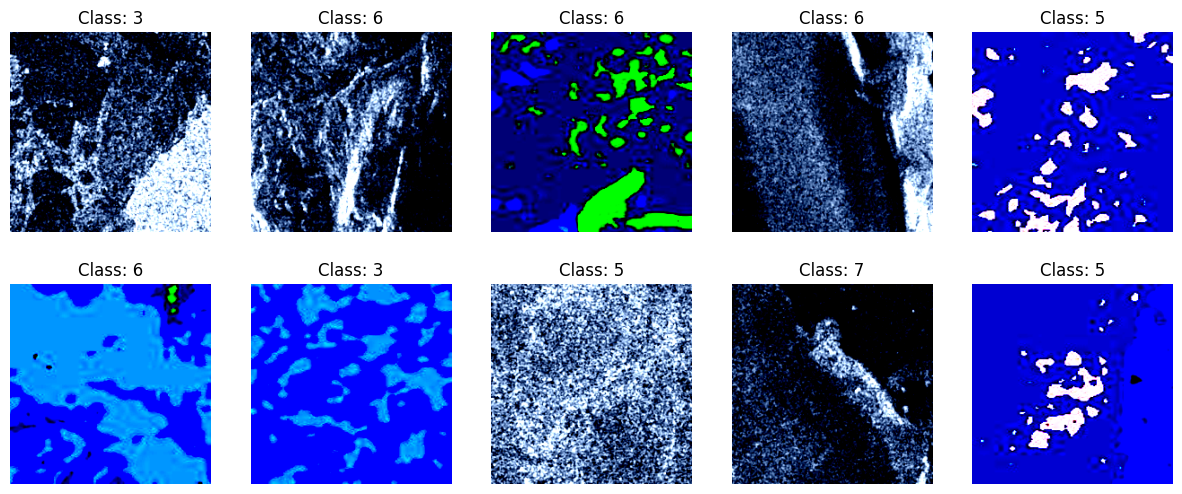

In [22]:
# Generate a random sample of 10 images from the test dataset
sample_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
sample_iter = iter(sample_loader)
sample_images, sample_labels = next(sample_iter)

# Display the sample images
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Transpose the tensor to (H, W, C) for display
    plt.title(f"Class: {sample_labels[i]}")
    plt.axis('off')
plt.show()


# Batch size and learning rate configurations


In [23]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 40

# Print the configuration
print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, and epochs: {num_epochs}")


Training with batch size: 32, learning rate: 0.0001, and epochs: 40


# Creating data loaders


In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initializing ShuffleNet Transfer Learning model


In [25]:
# Load pre-trained ShuffleNet model
model = models.shufflenet_v2_x1_0(pretrained=True)
num_classes = 8  # Change this according to your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

# Defining loss function and optimizer


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Lists to store loss and accuracy during training


In [27]:
loss_during_epoch = []
accuracy_during_epoch = []


# Training loop


In [28]:
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stopping = False

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        # Your existing training code...
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)


    # Validation
    model.eval()
    valid_loss = 0.0
    valid_correct_predictions = 0
    valid_total_predictions = 0

    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            valid_outputs = model(valid_inputs)
            valid_loss += criterion(valid_outputs, valid_labels).item()

            _, valid_predicted = torch.max(valid_outputs, 1)
            valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
            valid_total_predictions += valid_labels.size(0)


    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct_predictions / valid_total_predictions

    # Append to lists
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
          f"Running time: {elapsed_time}")

    # Early stopping logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            early_stopping = True
            break

# After the loop, you can check if early stopping occurred
if early_stopping:
    print("Training stopped due to early stopping.")
else:
    print("Training completed all epochs.")

Epoch 1, Loss: 1.5203810269768174, Accuracy: 61.53%, Validation Loss: 1.0549401028736218, Validation Accuracy: 69.36%, Running time: 46.51451826095581
Epoch 2, Loss: 0.9717317380039848, Accuracy: 69.83%, Validation Loss: 0.7587606262516331, Validation Accuracy: 74.81%, Running time: 42.16849446296692
Epoch 3, Loss: 0.7283252294689532, Accuracy: 76.05%, Validation Loss: 0.6280418070586952, Validation Accuracy: 79.71%, Running time: 42.72758960723877
Epoch 4, Loss: 0.6137796197388623, Accuracy: 80.22%, Validation Loss: 0.5437097485001022, Validation Accuracy: 82.21%, Running time: 43.06538462638855
Epoch 5, Loss: 0.5113085052106371, Accuracy: 83.13%, Validation Loss: 0.49896366048503565, Validation Accuracy: 84.28%, Running time: 41.98076128959656
Epoch 6, Loss: 0.45208365553594465, Accuracy: 85.24%, Validation Loss: 0.47492812594046463, Validation Accuracy: 85.42%, Running time: 42.200477600097656
Epoch 7, Loss: 0.3820007148856822, Accuracy: 87.43%, Validation Loss: 0.4593904149290678, 

# Saving the model weights


In [29]:
torch.save(model.state_dict(), f'SEAICE_ShuffleNeT_weights_batch_size_{batch_size}_lr_{learning_rate}_epochs_{num_epochs}.pth')


# Evaluation on test set


In [30]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


# Calculating evaluation metrics


In [31]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)


# Printing evaluation metrics



In [32]:
print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Epochs: {num_epochs}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Batch Size: 32, Learning Rate: 0.0001, Epochs: 40
Accuracy: 0.8512256973795436
Precision: 0.855625741547789
Recall: 0.8512256973795436
F1 Score: 0.8508034551694552


# Plotting confusion matrix


Confusion Matrix:


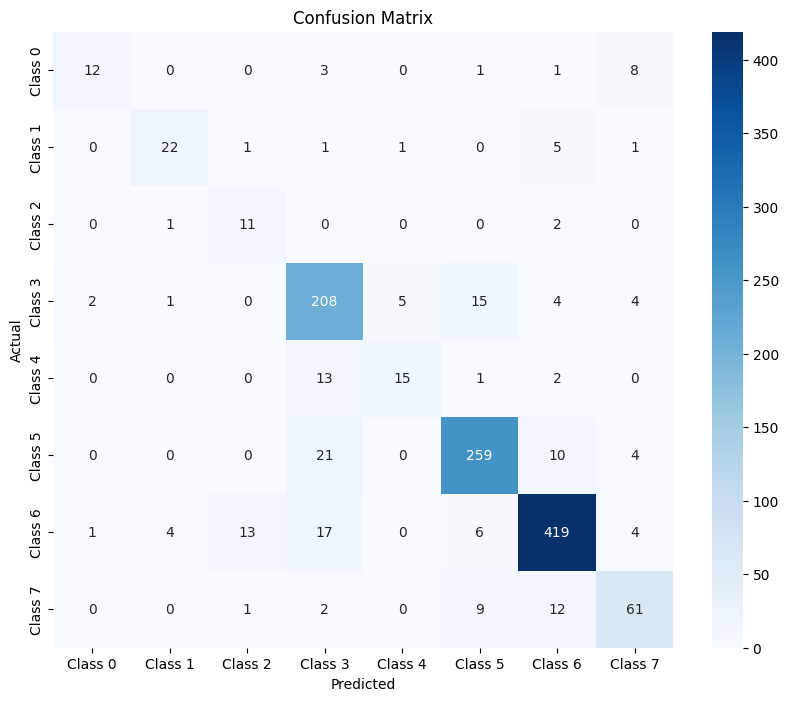

In [33]:
print("Confusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(cm))], yticklabels=[f'Class {i}' for i in range(len(cm))])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting accuracy and loss during training


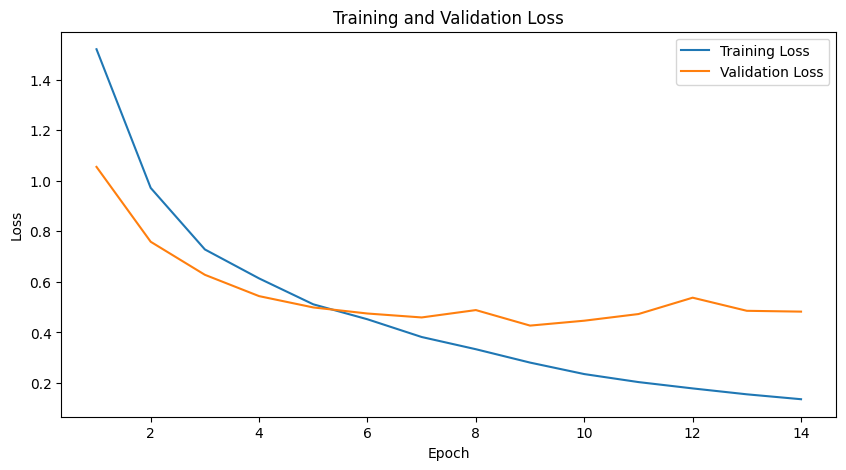

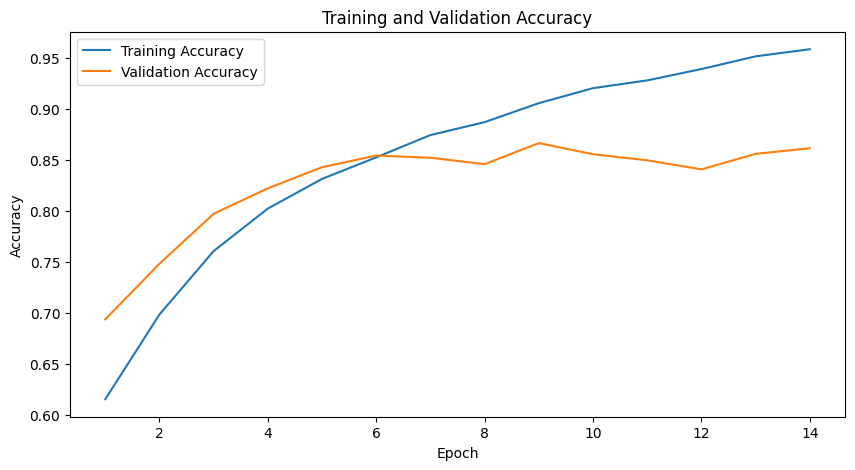

In [34]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 14 + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, 14 + 1), valid_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, 14 + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, 14 + 1), valid_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()